#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

##### Imports

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits, BaseShuffleSplit, _validate_shuffle_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from sklearn.utils import check_random_state
from sklearn.utils.validation import _num_samples, check_array
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import f1_score
import scipy.optimize as opt

import math
import cv2
import subprocess
from operator import itemgetter

In [3]:
np.random.seed(42)

##### Create sampling weights

In [4]:
def create_class_weight(labels_dict, mu=0.5):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    class_weight_log = dict()

    for key in keys:
        score = total / float(labels_dict[key])
        score_log = math.log(mu * total / float(labels_dict[key]))
        class_weight[key] = round(score, 2) if score > 1.0 else round(1.0, 2)
        class_weight_log[key] = round(score_log, 2) if score_log > 1.0 else round(1.0, 2)

    return class_weight, class_weight_log

# Class abundance for protein dataset
labels_dict = {
    0: 12885,
    1: 1254,
    2: 3621,
    3: 1561,
    4: 1858,
    5: 2513,
    6: 1008,
    7: 2822,
    8: 53,
    9: 45,
    10: 28,
    11: 1093,
    12: 688,
    13: 537,
    14: 1066,
    15: 21,
    16: 530,
    17: 210,
    18: 902,
    19: 1482,
    20: 172,
    21: 3777,
    22: 802,
    23: 2965,
    24: 322,
    25: 8228,
    26: 328,
    27: 11
}

weights = create_class_weight(labels_dict)[1]
class_weights = [weights[i] for i in range(28)]
print(class_weights)

[1.0, 3.01, 1.95, 2.79, 2.61, 2.31, 3.23, 2.2, 6.17, 6.34, 6.81, 3.15, 3.61, 3.86, 3.17, 7.1, 3.87, 4.8, 3.34, 2.84, 4.99, 1.91, 3.46, 2.15, 4.37, 1.13, 4.35, 7.74]


In [5]:
def softmax(x):
    x = np.array(x)
    return np.exp(x) / (1 + np.sum(np.exp(x)))

# class_weights = class_weights / np.sum(class_weights)
class_weights = softmax(class_weights)
dict({i:c for i, c in enumerate(class_weights)})

{0: 0.0004336997717298945,
 1: 0.003236839029880096,
 2: 0.0011214216890050657,
 3: 0.00259762416745741,
 4: 0.00216971808751918,
 5: 0.0016073666929768992,
 6: 0.00403334979579062,
 7: 0.0014399339515074009,
 8: 0.07629422486074063,
 9: 0.09043191485516268,
 10: 0.144690538649787,
 11: 0.0037232511271895205,
 12: 0.0058979052501823,
 13: 0.007573060246450145,
 14: 0.0037984657892148783,
 15: 0.19336841310878733,
 16: 0.007649170767265442,
 17: 0.019386893510800467,
 18: 0.004502339927530835,
 19: 0.002730807206495808,
 20: 0.023443593177759448,
 21: 0.0010774501156324283,
 22: 0.005076374093031132,
 23: 0.0013697075440114235,
 24: 0.012611350547208154,
 25: 0.0004939096098874133,
 26: 0.01236162907497985,
 27: 0.36671949812235627}

##### Create stratification

In [6]:
def IterativeStratification(labels, r, random_state):
    n_samples = labels.shape[0]
    test_folds = np.zeros(n_samples, dtype=int)
    c_folds = r * n_samples
    c_folds_labels = np.outer(r, labels.sum(axis=0))
    labels_not_processed_mask = np.ones(n_samples, dtype=bool)
    while np.any(labels_not_processed_mask):
        num_labels = labels[labels_not_processed_mask].sum(axis=0)
        if num_labels.sum() == 0:
            sample_idxs = np.where(labels_not_processed_mask)[0]

            for sample_idx in sample_idxs:
                fold_idx = np.where(c_folds == c_folds.max())[0]

                if fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(fold_idx.shape[0])]

                test_folds[sample_idx] = fold_idx
                c_folds[fold_idx] -= 1

            break
        label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
        if label_idx.shape[0] > 1:
            label_idx = label_idx[random_state.choice(label_idx.shape[0])]
        sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), labels_not_processed_mask))[0]
        for sample_idx in sample_idxs:
            label_folds = c_folds_labels[:, label_idx]
            fold_idx = np.where(label_folds == label_folds.max())[0]
            if fold_idx.shape[0] > 1:
                temp_fold_idx = np.where(c_folds[fold_idx] ==
                                         c_folds[fold_idx].max())[0]
                fold_idx = fold_idx[temp_fold_idx]
                if temp_fold_idx.shape[0] > 1:
                    fold_idx = fold_idx[random_state.choice(temp_fold_idx.shape[0])]
            test_folds[sample_idx] = fold_idx
            labels_not_processed_mask[sample_idx] = False
            c_folds_labels[fold_idx, labels[sample_idx]] -= 1
            c_folds[fold_idx] -= 1

    return test_folds


class MultilabelStratifiedKFold(_BaseKFold):
    def __init__(self, n_splits=3, shuffle=False, random_state=None):
        super(MultilabelStratifiedKFold, self).__init__(n_splits, shuffle, random_state)

    def _make_test_folds(self, X, y):
        y = np.asarray(y, dtype=bool)
        type_of_target_y = type_of_target(y)

        if type_of_target_y != 'multilabel-indicator':
            raise ValueError(
                'Supported target type is: multilabel-indicator. Got {!r} instead.'.format(type_of_target_y))

        num_samples = y.shape[0]

        rng = check_random_state(self.random_state)
        indices = np.arange(num_samples)

        if self.shuffle:
            rng.shuffle(indices)
            y = y[indices]

        r = np.asarray([1 / self.n_splits] * self.n_splits)

        test_folds = IterativeStratification(labels=y, r=r, random_state=rng)

        return test_folds[np.argsort(indices)]

    def _iter_test_masks(self, X=None, y=None, groups=None):
        test_folds = self._make_test_folds(X, y)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
            Note that providing ``y`` is sufficient to generate the splits and
            hence ``np.zeros(n_samples)`` may be used as a placeholder for
            ``X`` instead of actual training data.
        y : array-like, shape (n_samples, n_labels)
            The target variable for supervised learning problems.
            Multilabel stratification is done based on the y labels.
        groups : object
            Always ignored, exists for compatibility.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        Notes
        -----
        Randomized CV splitters may return different results for each call of
        split. You can make the results identical by setting ``random_state``
        to an integer.
        """
        y = check_array(y, ensure_2d=False, dtype=None)
        return super(MultilabelStratifiedKFold, self).split(X, y, groups)

##### Read data

In [7]:
path = Path('data')

In [8]:
train_df = pd.read_csv(path / 'all_data.csv')

In [9]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


##### Split data with Stratification and use first split

In [10]:
y = np.array(train_df.Target.str.split(' '))
y = [[int(k) for k in lst] for lst in y]
y[:5]

[[16, 0], [7, 1, 2, 0], [5], [1], [18]]

In [11]:
mlb = MultiLabelBinarizer()
y_onehot = mlb.fit_transform(y)
mlb.classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [12]:
msfk = MultilabelStratifiedKFold(5, random_state=42)
x = np.zeros((80058, 2))
trn_idx, tst_idx = None, None
for trn, tst in msfk.split(x, y_onehot):
    trn_idx = trn
    tst_idx = tst

In [13]:
len(trn_idx), len(tst_idx)

(64045, 16013)

##### Create model

In [14]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [15]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [16]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [17]:
src = (ImageItemList.from_csv(path, 'all_data.csv', folder='train', suffix='.png')
      .split_by_idxs(trn_idx, tst_idx)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [18]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [19]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [20]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [21]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [22]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [23]:
src.add_test(test_fnames, label='0');

In [24]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [25]:
# protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [26]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.05, max_lighting=0.05, max_warp=0.05,
                            xtra_tfms=[symmetric_warp(magnitude=(-0.2,0.2)), squish(scale=0.83)])

In [27]:
def get_sample_weights(labels, weight_per_class):
    sample_weights = [np.max(np.array(weight_per_class)[np.nonzero(lab)[0]]) for lab in labels]
    return sample_weights

# sample_weights = get_sample_weights(np.array(train_df.Target.str.split(' ')), np.array(class_weights))

sample_weights = get_sample_weights(np.array(train_df.iloc[trn_idx].Target.str.split(' ')), np.array(class_weights))
sampler = torch.utils.data.sampler.WeightedRandomSampler(sample_weights, len(sample_weights)) 

In [28]:
# data = (src.transform((trn_tfms, _), size=224).databunch(bs=64).normalize(protein_stats))
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize())

In [29]:
tmp = data.dl(DatasetType.Train)
tmp

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fc0896f8390>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fc0a8e9d620>, mean=tensor([0.0651, 0.0435, 0.0432, 0.0673]), std=tensor([0.1238, 0.0972, 0.1225, 0.1247]), do_y=None)], collate_fn=<function data_collate at 0x7fc0afd7f488>, skip_size1=True)

In [30]:
tmp2 = DeviceDataLoader.create(data.train_ds, bs=16, shuffle=False, device=torch.device('cuda'), sampler=sampler, tfms=tmp.tfms)
tmp2

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fc0896f8f60>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fc0a8e9d620>, mean=tensor([0.0651, 0.0435, 0.0432, 0.0673]), std=tensor([0.1238, 0.0972, 0.1225, 0.1247]), do_y=None)], collate_fn=<function data_collate at 0x7fc0afd7f488>, skip_size1=False)

In [31]:
data.train_dl = tmp2

In [32]:
data.dl(DatasetType.Train)

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fc0896f8f60>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7fc0a8e9d620>, mean=tensor([0.0651, 0.0435, 0.0432, 0.0673]), std=tensor([0.1238, 0.0972, 0.1225, 0.1247]), do_y=None)], collate_fn=<function data_collate at 0x7fc0afd7f488>, skip_size1=False)

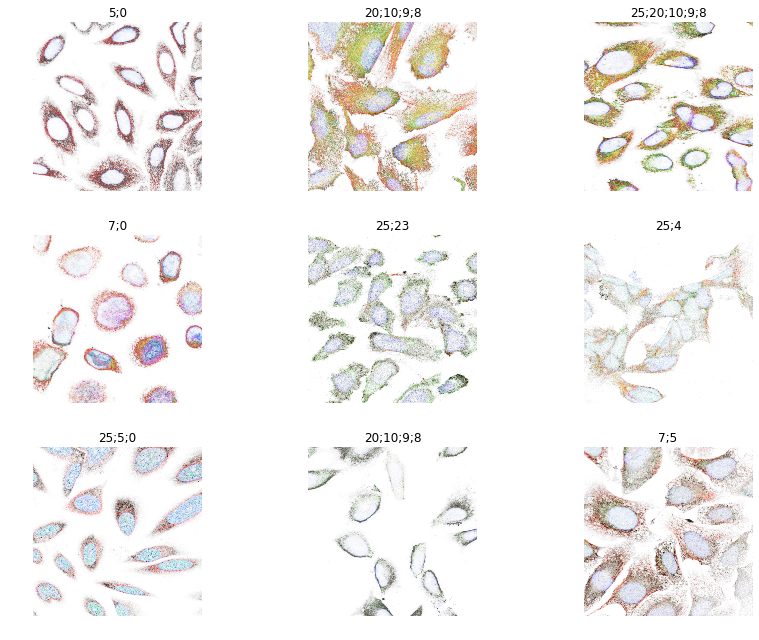

In [33]:
data.show_batch(rows=3, figsize=(12,9))

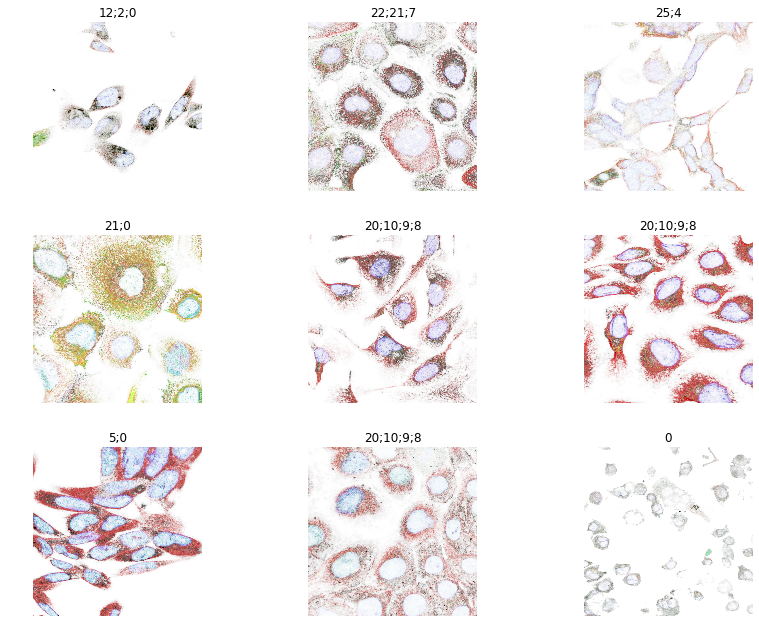

In [34]:
data.show_batch(rows=3, figsize=(12,9))

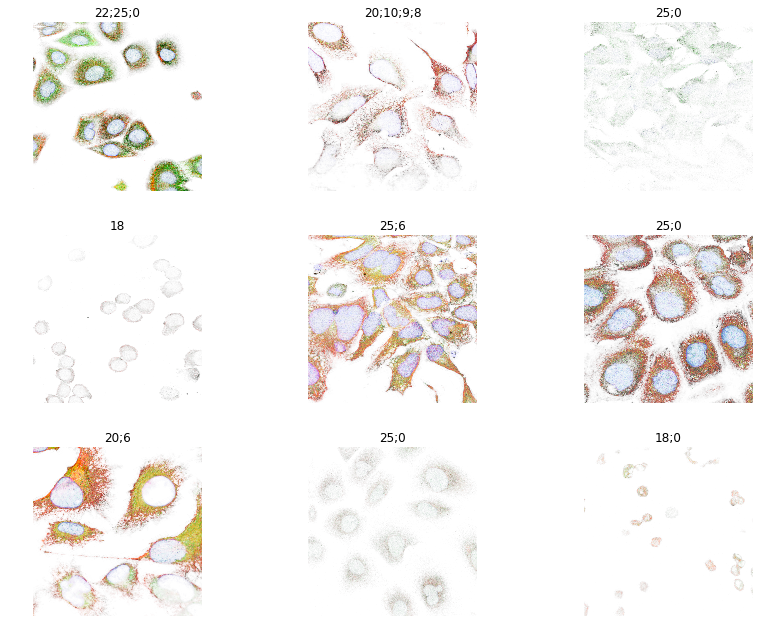

In [35]:
data.show_batch(rows=3, figsize=(12,9))

In [36]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [37]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [38]:
def _resnet_split(m): return (m[0][6],m[1])

In [39]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [40]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score]
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


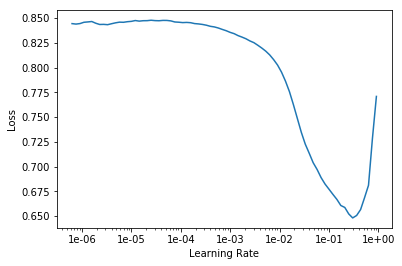

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(6, 1e-2)

Total time: 1:46:56
epoch  train_loss  valid_loss  fbeta   
1      0.156522    0.150887    0.512594  (17:48)
2      0.153962    0.130989    0.556352  (17:50)
3      0.143930    0.133367    0.544736  (17:40)
4      0.133858    0.113812    0.608774  (18:04)
5      0.123726    0.109178    0.623879  (17:50)
6      0.121301    0.104846    0.636806  (17:41)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


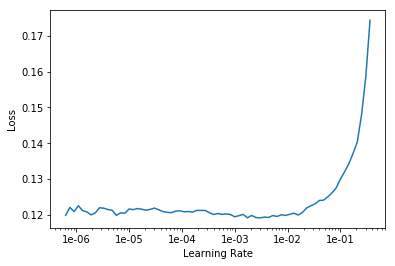

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.save("resnet101-224-weighted-sampling-external-data")

In [45]:
learn.fit_one_cycle(8, 1e-3)

Total time: 2:24:47
epoch  train_loss  valid_loss  fbeta   
1      0.121733    0.105194    0.633413  (18:19)
2      0.122004    0.104918    0.639781  (18:09)
3      0.121217    0.105521    0.631609  (17:56)
4      0.120382    0.103890    0.637876  (18:06)
5      0.119948    0.102501    0.645214  (17:54)
6      0.117937    0.101235    0.647869  (17:56)
7      0.119016    0.101740    0.646353  (18:13)
8      0.115638    0.101866    0.645606  (18:11)



In [46]:
learn.save("resnet101-224-weighted-sampling-external-data")

In [47]:
_ = learn.load("resnet101-224-weighted-sampling-external-data")

In [48]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


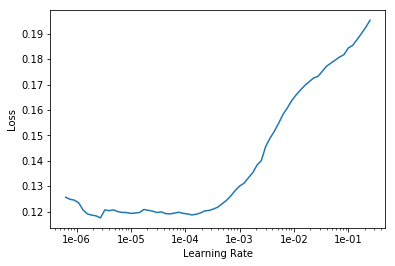

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.fit_one_cycle(8, slice(1e-6, 1e-4), wd=0.1)

Total time: 2:28:16
epoch  train_loss  valid_loss  fbeta   
1      0.117049    0.103377    0.642488  (18:15)
2      0.115871    0.104193    0.639231  (18:21)
3      0.118120    0.103431    0.637140  (18:54)
4      0.116665    0.101665    0.645730  (18:37)
5      0.112893    0.099624    0.655241  (18:25)
6      0.114193    0.099634    0.652101  (18:33)
7      0.113030    0.098865    0.654514  (18:42)
8      0.110302    0.098069    0.658541  (18:27)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


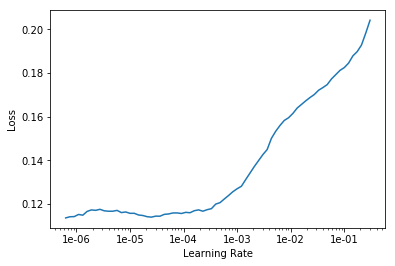

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.save("resnet101-224-weighted-sampling-external-data-unfreeze")

In [41]:
_ = learn.load("resnet101-224-weighted-sampling-external-data-unfreeze")

In [42]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-224-weighted-sampling-avg_pred-ext.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-224-weighted-sampling-preds_v1-ext.csv', header=True, index=False)
df.head()

Total time: 15:51



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 21 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


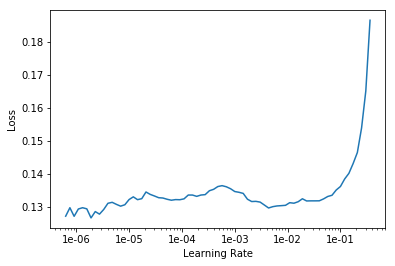

In [42]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, 3e-3, wd=0.15)

epoch,train_loss,valid_loss,fbeta
1,0.113679,0.091047,0.683337
2,0.115435,0.099371,0.655719
3,0.128366,0.113438,0.609934
4,0.132042,0.127799,0.575634
5,0.131920,0.110730,0.631875
6,0.132046,0.111883,0.616460
7,0.126286,0.109413,0.608565
8,0.117679,0.098289,0.662713
9,0.112302,0.091685,0.681038


In [ ]:
learn.save("resnet101-386-weighted-sampling-external-data")

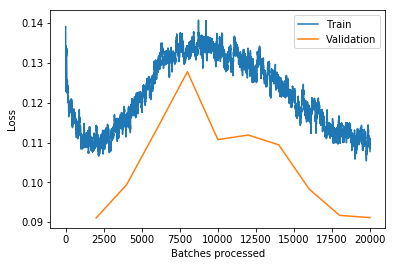

In [45]:
learn.recorder.plot_losses()

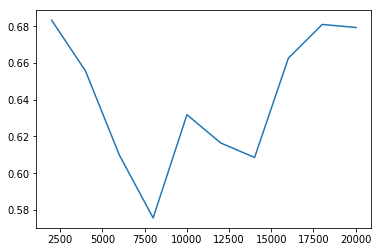

In [46]:
learn.recorder.plot_metrics()

In [47]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-avg_pred-ext.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-preds-ext.csv', header=True, index=False)
df.head()

Total time: 32:22



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 21 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 21 23 25


In [42]:
_ = learn.load("resnet101-386-weighted-sampling-external-data")

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


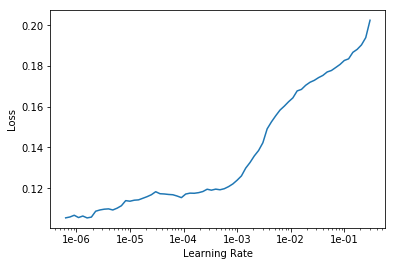

In [49]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(12, slice(1e-6, 1e-4), wd=0.15)

Total time: 6:35:37
epoch  train_loss  valid_loss  fbeta   
1      0.109264    0.093345    0.670514  (32:54)
2      0.106496    0.091879    0.676214  (32:54)
3      0.107388    0.093751    0.674165  (32:57)
4      0.109497    0.091605    0.675717  (32:57)
5      0.106371    0.091479    0.675136  (33:01)
6      0.104997    0.089860    0.684249  (33:00)
7      0.102348    0.089775    0.686130  (33:02)
8      0.097177    0.087797    0.692535  (32:59)
9      0.097735    0.087352    0.691412  (33:00)
10     0.099465    0.087898    0.688566  (32:58)
11     0.102723    0.086561    0.694607  (32:54)
12     0.103345    0.087056    0.692201  (32:56)



In [45]:
# With above close to 0.67 febta
learn.save("resnet101-386-weighted-sampling-external-data-unfreeze")

In [41]:
_ = learn.load("resnet101-386-weighted-sampling-external-data-unfreeze")

In [46]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-avg_pred-ext-unfreeze1.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-preds-ext-unfreeze1.csv', header=True, index=False)
df.head()

Total time: 31:54



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 21 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 23 25


In [42]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


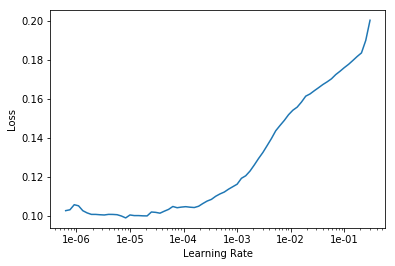

In [47]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(16, slice(1e-8, 5e-4), wd=0.1)

Total time: 8:46:28
epoch  train_loss  valid_loss  fbeta   
1      0.099905    0.087543    0.689628  (32:48)
2      0.099733    0.089369    0.686410  (32:43)
3      0.101055    0.087815    0.691052  (32:49)
4      0.104620    0.089636    0.687475  (32:49)
5      0.102158    0.087473    0.693337  (32:52)
6      0.099348    0.086692    0.696287  (32:54)
7      0.098852    0.087055    0.692602  (32:55)
8      0.097336    0.087744    0.692453  (32:52)
9      0.099088    0.088153    0.686915  (32:56)
10     0.097584    0.086697    0.694677  (32:57)
11     0.098573    0.086428    0.695152  (32:58)
12     0.099082    0.088059    0.687370  (32:59)
13     0.098187    0.085586    0.696214  (32:57)
14     0.093100    0.085826    0.695720  (32:57)
15     0.093609    0.087286    0.691083  (32:59)
16     0.091859    0.086130    0.696771  (32:58)



In [44]:
learn.save("resnet101-386-weighted-sampling-external-data-unfreeze-2")

In [45]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-avg_pred-ext-unfreeze2.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-386-weighted-sampling-preds-ext-unfreeze2.csv', header=True, index=False)
df.head()

Total time: 32:19



,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0 2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0 5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 2 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 25


In [41]:
_ = learn.load("resnet101-386-weighted-sampling-external-data-unfreeze-2")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


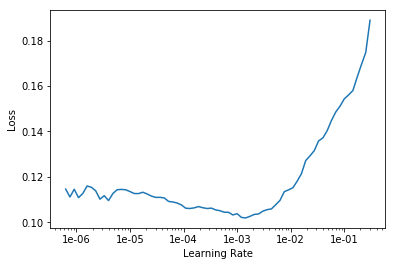

In [42]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, 5e-5, wd=0.2)

epoch,train_loss,valid_loss,fbeta
1,0.104417,0.105307,0.648015
2,0.100039,0.104082,0.652251
3,0.095239,0.099836,0.663168
4,0.102809,0.097262,0.666910
5,0.100596,0.098616,0.660226
6,0.099353,0.100416,0.660349
7,0.095297,0.096162,0.670622
8,0.096957,0.096562,0.669466
9,0.093267,0.096737,0.667500


In [41]:
# With above 0.69 fbeta

In [41]:
_ = learn.load("resnet101-512-weighted-sampling-external-data-freeze")

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(16, slice(1e-6, 1e-4), wd=0.1)

Total time: 14:11:00
epoch  train_loss  valid_loss  fbeta   
1      0.101900    0.096800    0.669358  (53:51)
2      0.099841    0.095026    0.669499  (53:17)
3      0.093786    0.094193    0.682649  (53:08)
4      0.099379    0.103673    0.649552  (52:57)
5      0.097567    0.096334    0.671079  (52:50)
6      0.099157    0.098011    0.662265  (53:08)
7      0.094760    0.100602    0.654878  (52:51)
8      0.098711    0.099380    0.667197  (53:13)
9      0.094488    0.093102    0.681157  (52:53)
10     0.093381    0.094341    0.676346  (52:54)
11     0.093349    0.095322    0.675191  (52:54)
12     0.094632    0.092518    0.681960  (53:24)
13     0.090513    0.096438    0.676480  (53:42)
14     0.088610    0.093565    0.685053  (53:31)
15     0.090428    0.095089    0.681407  (53:13)
16     0.088825    0.096882    0.677168  (53:07)



In [44]:
learn.save("resnet101-512-weighted-sampling-external-data-unfreeze-1")

In [ ]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-512-weighted-sampling-avg_pred-ext-unfreeze1.csv', header=True, index=False)
df.head()

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101-512-weighted-sampling-preds-ext-unfreeze1.csv', header=True, index=False)
df.head()

/home/deep/fastai-env/lib/python3.6/site-packages/torch/nn/functional.py:1174: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
